# MemXLNet-QA Evaluation Notebook

This notebook demonstrates how to load and evaluate the MemXLNet-QA model from checkpoint using the proper data pipeline.

**Goal**: Achieve F1 score > 80% on SQuAD v2

## Features Demonstrated:
- ✅ Model loading with memory state restoration
- ✅ Time-step-major batching for proper memory propagation  
- ✅ Complete evaluation pipeline using `create_evaluation_dataloader`
- ✅ Memory-aware document processing
- ✅ SQuAD v2 metrics computation with HasAns/NoAns breakdown

## Configuration Parameters

Define all adjustable parameters in one place for reproducibility and easier experimentation.

In [1]:
import sys
import os
import torch
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

# Add src to path for imports
sys.path.append('../src')
sys.path.append('..')

# Import MemXLNet-QA components using proper module paths
from src.memxlnet_qa import MemXLNetForQA
from src.train import TrainingConfig, XLNetRecurrentTrainer
from src.data import create_evaluation_dataloader  # Use proper pipeline!
from transformers import XLNetTokenizerFast
from datasets import load_dataset

print("✅ All imports successful")

/Users/tupa7/private/paper-revise/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports successful


In [ ]:
# Central configuration
from dataclasses import dataclass
import time

@dataclass
class EvalConfig:
    checkpoint_path: str = '../outputs/xlnet-squad-phase2-1/stage_2_segs_2/best_model'
    test_size: int = 100
    batch_size: int = 8
    max_answer_length: int = 30
    start_top_k: int = 24
    end_top_k: int = 24
    no_answer_threshold: float = 1.5  # higher => predict more answers (tune)
    use_full_eval: bool = True  # ✅ ENABLED: Run full dataset evaluation

EVAL_CFG = EvalConfig()
print(EVAL_CFG)

## 1. Load Model and Configuration

Load the trained MemXLNet-QA model with memory state restoration and examine the configuration.

In [3]:
# Path to the trained checkpoint (adjust if your checkpoint is elsewhere)
checkpoint_path = '../outputs/xlnet-squad-phase2-1/stage_2_segs_2/best_model'
config_path = os.path.join(checkpoint_path, 'training_config.json')

print(f"Loading model from: {checkpoint_path}")
print(f"Loading config from: {config_path}")

# Verify checkpoint exists
if not os.path.exists(checkpoint_path):
    print(f"❌ Checkpoint not found at {checkpoint_path}")
    print("Available checkpoints:")
    outputs_dir = '../outputs'
    if os.path.exists(outputs_dir):
        for item in os.listdir(outputs_dir):
            item_path = os.path.join(outputs_dir, item)
            if os.path.isdir(item_path):
                print(f"  {item}")
    else:
        print("  No outputs directory found")
else:
    print("✅ Checkpoint directory found")

# Load training configuration
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config_data = json.load(f)
    
    print("\n📋 Training Configuration:")
    key_configs = ['max_seq_length', 'doc_stride', 'no_answer_threshold', 
                   'memory_num_tokens', 'memory_update', 'memory_init', 'memory_impl']
    for key in key_configs:
        if key in config_data:
            print(f"  {key}: {config_data[key]}")
else:
    print(f"❌ Config file not found: {config_path}")
    config_data = {}  # Use defaults

Loading model from: ../outputs/xlnet-squad-phase2-1/stage_2_segs_2/best_model
Loading config from: ../outputs/xlnet-squad-phase2-1/stage_2_segs_2/best_model/training_config.json
✅ Checkpoint directory found

📋 Training Configuration:
  max_seq_length: 384
  doc_stride: 64
  no_answer_threshold: 1.5
  memory_num_tokens: 16
  memory_update: gated
  memory_init: learned
  memory_impl: token


In [4]:
# Load the MemXLNet model with memory state restoration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if os.path.exists(checkpoint_path):
    # Load model using the fixed from_pretrained method
    print("Loading MemXLNet-QA model...")
    model = MemXLNetForQA.from_pretrained(checkpoint_path)
    model.to(device)
    model.eval()
    
    print(f"\n🎯 Model loaded successfully:")
    print(f"  Memory tokens: {model.mem_token_count}")
    print(f"  Memory update: {model.memory_update}")
    print(f"  Memory init: {model.memory_init}")
    print(f"  Base model: {type(model.base).__name__}")
    
    # Check memory parameters
    total_params = sum(p.numel() for p in model.parameters())
    memory_params = 0
    if hasattr(model, 'learned_memory'):
        memory_params += model.learned_memory.numel()
    if hasattr(model, 'memory_gate'):
        memory_params += sum(p.numel() for p in model.memory_gate.parameters())
    if hasattr(model, 'memory_update_net'):
        memory_params += sum(p.numel() for p in model.memory_update_net.parameters())
    
    print(f"  Total parameters: {total_params:,}")
    print(f"  Memory parameters: {memory_params:,} ({memory_params/total_params*100:.1f}%)")
    
    # Load tokenizer with memory tokens
    print("\nLoading tokenizer...")
    tokenizer = XLNetTokenizerFast.from_pretrained(checkpoint_path)
    print(f"  Vocabulary size: {len(tokenizer)}")
    print(f"  Original XLNet vocab: ~32000")
    print(f"  Added memory tokens: {len(tokenizer) - 32000}")
    
    # Check for memory tokens
    memory_tokens = [token for token in tokenizer.get_vocab().keys() if 'mem_' in token.lower()]
    print(f"  Memory tokens found: {len(memory_tokens)}")
    if memory_tokens:
        print(f"  Examples: {memory_tokens[:4]} ... {memory_tokens[-4:]}")
        
else:
    print("❌ Cannot load model - checkpoint not found")
    model = None
    tokenizer = None

Using device: cpu
Loading MemXLNet-QA model...

🎯 Model loaded successfully:
  Memory tokens: 16
  Memory update: gated
  Memory init: learned
  Base model: XLNetForQuestionAnsweringSimple
  Total parameters: 119,117,570
  Memory parameters: 2,373,120 (2.0%)

Loading tokenizer...
  Vocabulary size: 32032
  Original XLNet vocab: ~32000
  Added memory tokens: 32
  Memory tokens found: 32
  Examples: ['<mem_w_6>', '<mem_w_3>', '<mem_w_4>', '<mem_r_10>'] ... ['<mem_w_5>', '<mem_r_6>', '<mem_r_4>', '<mem_r_9>']


## 2. Load SQuAD v2 Dataset

In [5]:
# Load SQuAD v2 validation set
print("Loading SQuAD v2 validation dataset...")
dataset = load_dataset("squad_v2", split="validation")
print(f"Dataset size: {len(dataset)} examples")

# Show dataset statistics
has_answer = sum(1 for ex in dataset if len(ex['answers']['text']) > 0)
no_answer = len(dataset) - has_answer

print(f"\nDataset breakdown:")
print(f"  Has answer: {has_answer} ({has_answer/len(dataset)*100:.1f}%)")
print(f"  No answer: {no_answer} ({no_answer/len(dataset)*100:.1f}%)")

# Show example
example = dataset[0]
print(f"\nExample:")
print(f"  Question: {example['question'][:100]}...")
print(f"  Context: {example['context'][:100]}...")
print(f"  Answer: {example['answers']['text']}")

Loading SQuAD v2 validation dataset...
Dataset size: 11873 examples

Dataset breakdown:
  Has answer: 5928 (49.9%)
  No answer: 5945 (50.1%)

Example:
  Question: In what country is Normandy located?...
  Context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th a...
  Answer: ['France', 'France', 'France', 'France']
Dataset size: 11873 examples

Dataset breakdown:
  Has answer: 5928 (49.9%)
  No answer: 5945 (50.1%)

Example:
  Question: In what country is Normandy located?...
  Context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th a...
  Answer: ['France', 'France', 'France', 'France']


## 2. Setup Evaluation Pipeline

Use the proper `create_evaluation_dataloader` function for time-step-major batching with memory support.

In [6]:
# Now we can use the proper data pipeline functions!
from data import create_evaluation_dataloader

In [ ]:
def evaluate_with_memory(model, eval_dataloader, eval_dataset, device, no_answer_threshold=None,
                           max_answer_length=None, start_top_k=None, end_top_k=None):
    """
    Memory-aware evaluation using time-step-major batches.

    Args:
        model: MemXLNetForQA
        eval_dataloader: iterator yielding list[batch_dict] per document batch (time-step-major)
        eval_dataset: SquadLikeQADataset (for optional context)
        device: torch.device
        no_answer_threshold: float; if (null_score - best_non_null_score) > threshold => predict no answer
        max_answer_length: int maximum token span length
        start_top_k / end_top_k: prune span search by top-k logits for efficiency
    Returns:
        List of per-segment prediction dicts with keys:
            example_id, example_index, time_step, prediction, best_start, best_end,
            best_non_null_score, null_score, confidence
    """
    model.eval()
    if no_answer_threshold is None:
        no_answer_threshold = EVAL_CFG.no_answer_threshold
    if max_answer_length is None:
        max_answer_length = EVAL_CFG.max_answer_length
    if start_top_k is None:
        start_top_k = EVAL_CFG.start_top_k
    if end_top_k is None:
        end_top_k = EVAL_CFG.end_top_k

    all_predictions = []
    with torch.no_grad():
        for batch_idx, time_step_batches in enumerate(tqdm(eval_dataloader, desc="Evaluating")):
            memory_bank = {}
            for time_step, batch in enumerate(time_step_batches):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch.get('token_type_ids')
                if token_type_ids is not None:
                    token_type_ids = token_type_ids.to(device)
                document_mask = batch['document_mask'].to(device)
                example_ids = batch['example_ids']
                offset_mapping = batch['offset_mapping']  # list[list[tuple]]
                contexts = batch['context']
                cls_indices = batch.get('cls_index', [])  # Get CLS indices from batch

                # Prepare memory states
                memory_states = []
                for ex_id, active in zip(example_ids, document_mask.tolist()):
                    if not active or ex_id.startswith('padding'):
                        memory_states.append(model.get_initial_memory(1, device)[0])
                    else:
                        prev_memory = memory_bank.get(ex_id)
                        if prev_memory is None:
                            prev_memory = model.get_initial_memory(1, device)[0]
                        memory_states.append(prev_memory)
                memory_state_batch = torch.stack(memory_states, dim=0)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    memory_state=memory_state_batch,
                )
                start_logits = outputs['start_logits'].cpu().numpy()
                end_logits = outputs['end_logits'].cpu().numpy()
                new_memory_state = outputs['new_memory_state']

                # Update memory
                for i, (ex_id, active) in enumerate(zip(example_ids, document_mask.tolist())):
                    if active and not ex_id.startswith('padding'):
                        memory_bank[ex_id] = new_memory_state[i].detach()

                active_mask = document_mask.bool()
                if not active_mask.any():
                    continue

                active_indices = torch.where(active_mask)[0].tolist()
                for tensor_idx in active_indices:
                    i = tensor_idx
                    ex_id = example_ids[i]
                    if ex_id.startswith('padding'):
                        continue
                    # Parse example index from doc_X id
                    try:
                        example_index = int(ex_id.split('_')[1])
                    except Exception:
                        example_index = -1

                    s_logits = start_logits[i]
                    e_logits = end_logits[i]

                    # Get CLS index for this example (CRITICAL FIX!)
                    cls_idx = 0  # Fallback to position 0
                    if i < len(cls_indices):
                        cls_idx = int(cls_indices[i]) if isinstance(cls_indices[i], torch.Tensor) else cls_indices[i]
                    elif hasattr(input_ids, 'tolist'):
                        # Try to find CLS token in input_ids
                        input_ids_list = input_ids[i].tolist()
                        try:
                            cls_idx = input_ids_list.index(tokenizer.cls_token_id) if hasattr(tokenizer, 'cls_token_id') else 0
                        except ValueError:
                            cls_idx = 0

                    # Determine context mask
                    if token_type_ids is not None:
                        context_mask = (token_type_ids[i] == 1).cpu().numpy()
                    else:
                        # fallback heuristic: second half
                        seq_len = len(s_logits)
                        context_mask = np.zeros(seq_len, dtype=bool)
                        context_mask[seq_len//2:] = True

                    candidate_starts = np.argsort(s_logits)[-start_top_k:][::-1]
                    candidate_ends = np.argsort(e_logits)[-end_top_k:][::-1]

                    best_span = (0, 0)
                    best_non_null_score = -float('inf')
                    for s in candidate_starts:
                        if not context_mask[s]:
                            continue
                        for e in candidate_ends:
                            if e < s:
                                continue
                            length = e - s + 1
                            if length > max_answer_length:
                                continue
                            if not context_mask[e]:
                                continue
                            score = s_logits[s] + e_logits[e]
                            if score > best_non_null_score:
                                best_non_null_score = score
                                best_span = (s, e)

                    # ✅ FIXED: Use actual CLS index instead of hardcoded position 0
                    null_score = s_logits[cls_idx] + e_logits[cls_idx]
                    predict_empty = (null_score - best_non_null_score) > no_answer_threshold

                    pred_text = ""
                    if not predict_empty and best_non_null_score > -float('inf'):
                        om = offset_mapping[i]
                        if best_span[0] < len(om) and best_span[1] < len(om):
                            start_off = om[best_span[0]]
                            end_off = om[best_span[1]]
                            if start_off != (0, 0) and end_off != (0, 0):
                                char_start = start_off[0]
                                char_end = end_off[1]
                                ctx = contexts[i]
                                if 0 <= char_start < char_end <= len(ctx):
                                    pred_text = ctx[char_start:char_end].strip()

                    all_predictions.append({
                        'example_id': ex_id,
                        'example_index': example_index,
                        'time_step': time_step,
                        'prediction': pred_text,
                        'best_start': best_span[0],
                        'best_end': best_span[1],
                        'best_non_null_score': float(best_non_null_score),
                        'null_score': float(null_score),
                        'confidence': float(best_non_null_score - null_score),
                        'predicted_empty': bool(predict_empty),
                        'cls_index_used': int(cls_idx)  # Debug info
                    })
    return all_predictions

In [8]:
from collections import defaultdict
import numpy as np


def aggregate_document_predictions(predictions, total_examples, choose='confidence'):
    """Aggregate per-segment predictions into one per document.

    Args:
        predictions: list of dicts from evaluate_with_memory
        total_examples: int number of examples
        choose: 'confidence' | 'best_non_null_score'
    Returns:
        final_predictions: list[str]
        doc_meta: list[dict] with aggregation details per example index
    """
    by_doc = defaultdict(list)
    for p in predictions:
        if p['example_index'] >= 0:
            by_doc[p['example_index']].append(p)

    final_predictions = []
    doc_meta = []
    for idx in range(total_examples):
        seg_preds = by_doc.get(idx, [])
        if not seg_preds:
            final_predictions.append("")
            doc_meta.append({'example_index': idx, 'segments': 0, 'chosen': None})
            continue
        key = 'confidence' if choose == 'confidence' else 'best_non_null_score'
        chosen = max(seg_preds, key=lambda x: x[key])
        final_predictions.append(chosen['prediction'])
        doc_meta.append({
            'example_index': idx,
            'segments': len(seg_preds),
            'chosen_confidence': chosen['confidence'],
            'chosen_null_score': chosen['null_score'],
            'predicted_empty': chosen['predicted_empty'],
            'time_step': chosen['time_step']
        })
    return final_predictions, doc_meta


def compute_metrics(predictions, examples):
    import string, re

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_f1(prediction, ground_truth):
        pred_tokens = normalize_answer(prediction).split()
        gt_tokens = normalize_answer(ground_truth).split()
        if len(pred_tokens) == 0 and len(gt_tokens) == 0:
            return 1.0
        if len(pred_tokens) == 0 or len(gt_tokens) == 0:
            return 0.0
        common_tokens = set(pred_tokens) & set(gt_tokens)
        if len(common_tokens) == 0:
            return 0.0
        precision = len(common_tokens) / len(pred_tokens)
        recall = len(common_tokens) / len(gt_tokens)
        return 2 * precision * recall / (precision + recall)

    exact_match = 0
    f1_scores = []
    has_answer_exact = 0
    has_answer_f1 = []
    no_answer_exact = 0
    no_answer_f1 = []

    for pred, ex in zip(predictions, examples):
        gts = ex['answers']['text']
        if len(gts) == 0:  # no-answer
            is_correct = (pred == "")
            exact_match += int(is_correct)
            no_answer_exact += int(is_correct)
            score = 1.0 if is_correct else 0.0
            f1_scores.append(score)
            no_answer_f1.append(score)
        else:
            max_f1 = 0.0
            max_exact = 0
            for gt in gts:
                exact = int(normalize_answer(pred) == normalize_answer(gt))
                f1 = compute_f1(pred, gt)
                if f1 > max_f1:
                    max_f1 = f1
                if exact > max_exact:
                    max_exact = exact
            exact_match += max_exact
            has_answer_exact += max_exact
            has_answer_f1.append(max_f1)
            f1_scores.append(max_f1)

    total = len(examples)
    has_ans_count = sum(1 for ex in examples if len(ex['answers']['text']) > 0)
    no_ans_count = total - has_ans_count

    return {
        'f1': float(np.mean(f1_scores) * 100),
        'exact_match': exact_match / total * 100,
        'has_answer_f1': float(np.mean(has_answer_f1) * 100) if has_answer_f1 else 0.0,
        'has_answer_exact': has_answer_exact / has_ans_count * 100 if has_ans_count else 0.0,
        'no_answer_f1': float(np.mean(no_answer_f1) * 100) if no_answer_f1 else 0.0,
        'no_answer_exact': no_answer_exact / no_ans_count * 100 if no_ans_count else 0.0,
        'total_examples': total,
        'has_answer_count': has_ans_count,
        'no_answer_count': no_ans_count
    }

print("✅ Aggregation & metrics utilities ready")

✅ Aggregation & metrics utilities ready


## 3. Memory-Aware Evaluation Functions

Implement evaluation with proper time-step-major batching and memory state propagation.

In [9]:
# Test evaluation setup with a small subset first
test_size = 100  # Start with 100 examples for testing

if model is not None and tokenizer is not None:
    print(f"📊 Creating evaluation dataset for {test_size} examples using proper pipeline...")
    
    # Use the proper data pipeline from src.data
    eval_dataset, eval_dataloader = create_evaluation_dataloader(
        dataset_name="squad_v2",
        split="validation",
        tokenizer=tokenizer,  # Include memory tokens
        max_seq_length=config_data.get('max_seq_length', 384),
        doc_stride=config_data.get('doc_stride', 64),
        batch_size=8,
        max_examples=test_size,
        max_n_segs=config_data.get('max_n_segs', None),
        cache_dir="../.cache",
        use_time_step_major=True,  # Enable time-step-major batching
    )
    
    print(f"✅ Evaluation pipeline created:")
    print(f"  Dataset features: {len(eval_dataset)}")
    print(f"  Documents: {len(eval_dataset.get_all_documents())}")
    print(f"  DataLoader batches: {len(eval_dataloader)}")
    print(f"  Memory tokens in tokenizer: {len(tokenizer) - 32000}")
    
    # Show document structure for first few documents
    print(f"\n📋 Document structure (first 3 documents):")
    for doc_id in eval_dataset.get_all_documents()[:3]:
        segments = eval_dataset.get_document_segments(doc_id)
        print(f"  {doc_id}: {len(segments)} segments at indices {segments}")
        
else:
    print("❌ Cannot create evaluation pipeline - model or tokenizer not loaded")
    eval_dataset = None
    eval_dataloader = None

📊 Creating evaluation dataset for 100 examples using proper pipeline...
Processing and caching squad_v2 validation...
✓ Processed 107 features
Creating dataset from cache...
[create_dataset_from_cache] Checking cache for 'squad_v2_mem32_v1' (validation) in ../.cache ...
[create_dataset_from_cache] Cache hit: 1 chunk(s) detected. Loading ...
[create_dataset_from_cache] Reconstructed dataset with 107 features across 100 documents (cache).
✓ Dataset created: 107 features
Creating dataloader...
✓ DataLoader created: 13 batches
✅ Evaluation pipeline created:
  Dataset features: 107
  Documents: 100
  DataLoader batches: 13
  Memory tokens in tokenizer: 32

📋 Document structure (first 3 documents):
  doc_0: 1 segments at indices [0]
  doc_1: 1 segments at indices [1]
  doc_2: 1 segments at indices [2]
[create_dataset_from_cache] Reconstructed dataset with 107 features across 100 documents (cache).
✓ Dataset created: 107 features
Creating dataloader...
✓ DataLoader created: 13 batches
✅ Evalu

In [10]:
# Run evaluation with memory-aware processing on test subset
if model is not None and eval_dataloader is not None:
    print("🧠 Running evaluation subset with time-step-major batching & memory...")

    squad_dataset = load_dataset("squad_v2", split="validation")
    test_examples = squad_dataset.select(range(EVAL_CFG.test_size))

    raw_predictions = evaluate_with_memory(
        model=model,
        eval_dataloader=eval_dataloader,
        eval_dataset=eval_dataset,
        device=device,
        no_answer_threshold=EVAL_CFG.no_answer_threshold,
        max_answer_length=EVAL_CFG.max_answer_length,
        start_top_k=EVAL_CFG.start_top_k,
        end_top_k=EVAL_CFG.end_top_k,
    )

    print(f"✅ Collected {len(raw_predictions)} segment-level predictions")

    final_predictions, doc_meta = aggregate_document_predictions(
        raw_predictions, EVAL_CFG.test_size, choose='confidence'
    )
    assert len(final_predictions) == EVAL_CFG.test_size

    print(f"✅ Aggregated to {len(final_predictions)} document predictions")

    # Preview
    print("\n📋 Example predictions (first 5):")
    for i in range(min(5, EVAL_CFG.test_size)):
        example = test_examples[i]
        prediction = final_predictions[i]
        ground_truth = example['answers']['text']
        print(f"\n--- Example {i+1} ---")
        print(f"Question: {example['question'][:80]}...")
        print(f"Prediction: '{prediction}'")
        print(f"Ground truth: {ground_truth}")
        print(f"Has answer: {len(ground_truth) > 0}")

    subset_metrics = compute_metrics(final_predictions, test_examples)
    print(f"\n🎯 SUBSET RESULTS ({EVAL_CFG.test_size} examples):")
    print('=' * 60)
    for k in ['f1','exact_match','has_answer_f1','has_answer_exact','no_answer_f1','no_answer_exact']:
        print(f"{k}: {subset_metrics[k]:.2f}%")
    print('=' * 60)
else:
    print("❌ Cannot run subset evaluation - model or dataloader not available")
    subset_metrics = None

🧠 Running evaluation subset with time-step-major batching & memory...


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]/Users/tupa7/private/paper-revise/notebooks/../src/data.py:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item[key] = torch.tensor(feature[key])
/Users/tupa7/private/paper-revise/notebooks/../src/data.py:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item[key] = torch.tensor(feature[key])
Evaluating: 100%|██████████| 13/13 [00:24<00:00,  1.86s/it]

✅ Collected 107 segment-level predictions
✅ Aggregated to 100 document predictions

📋 Example predictions (first 5):

--- Example 1 ---
Question: In what country is Normandy located?...
Prediction: 'France'
Ground truth: ['France', 'France', 'France', 'France']
Has answer: True

--- Example 2 ---
Question: When were the Normans in Normandy?...
Prediction: '10th and 11th centuries'
Ground truth: ['10th and 11th centuries', 'in the 10th and 11th centuries', '10th and 11th centuries', '10th and 11th centuries']
Has answer: True

--- Example 3 ---
Question: From which countries did the Norse originate?...
Prediction: 'Denmark, Iceland and Norway'
Ground truth: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
Has answer: True

--- Example 4 ---
Question: Who was the Norse leader?...
Prediction: 'Rollo'
Ground truth: ['Rollo', 'Rollo', 'Rollo', 'Rollo']
Has answer: True

--- Example 5 ---
Question: What century did t

## 4. Run Evaluation

Execute the complete evaluation pipeline with memory-enabled processing.

## 5. Full Dataset Evaluation

Now let's run on the complete SQuAD v2 validation set to get the final F1 score.

In [11]:
# Full evaluation pipeline (optional)
if model is not None and tokenizer is not None and subset_metrics is not None and EVAL_CFG.use_full_eval:
    print("📊 Building full evaluation dataloader...")
    full_eval_dataset, full_eval_dataloader = create_evaluation_dataloader(
        dataset_name="squad_v2",
        split="validation",
        tokenizer=tokenizer,
        max_seq_length=config_data.get('max_seq_length', 384),
        doc_stride=config_data.get('doc_stride', 64),
        batch_size=EVAL_CFG.batch_size,
        max_examples=None,
        max_n_segs=config_data.get('max_n_segs', None),
        cache_dir="../.cache",
        use_time_step_major=True,
    )
    print(f"✅ Full dataset features: {len(full_eval_dataset)}")
else:
    full_eval_dataset = None
    full_eval_dataloader = None
    print("ℹ️ Full evaluation skipped (set EVAL_CFG.use_full_eval=True to enable)")

ℹ️ Full evaluation skipped (set EVAL_CFG.use_full_eval=True to enable)


In [12]:
# Execute full evaluation if enabled
if full_eval_dataloader is not None:
    print("🚀 Running full validation evaluation...")
    full_squad_dataset = load_dataset("squad_v2", split="validation")

    full_raw_predictions = evaluate_with_memory(
        model=model,
        eval_dataloader=full_eval_dataloader,
        eval_dataset=full_eval_dataset,
        device=device,
        no_answer_threshold=EVAL_CFG.no_answer_threshold,
        max_answer_length=EVAL_CFG.max_answer_length,
        start_top_k=EVAL_CFG.start_top_k,
        end_top_k=EVAL_CFG.end_top_k,
    )
    print(f"✅ Collected {len(full_raw_predictions)} segment-level predictions")

    full_final_predictions, full_doc_meta = aggregate_document_predictions(
        full_raw_predictions, len(full_squad_dataset)
    )
    assert len(full_final_predictions) == len(full_squad_dataset)

    final_metrics = compute_metrics(full_final_predictions, full_squad_dataset)

    print("\n🏆 FULL VALIDATION RESULTS:")
    print('=' * 70)
    for k in ['f1','exact_match','has_answer_f1','has_answer_exact','no_answer_f1','no_answer_exact']:
        print(f"{k}: {final_metrics[k]:.2f}%")
    print('=' * 70)

    goal_achieved = final_metrics['f1'] >= 80.0
    print("\nGoal:", '✅ Achieved' if goal_achieved else '📈 Not yet')
else:
    full_raw_predictions = None
    full_final_predictions = None
    full_doc_meta = None
    final_metrics = None
    goal_achieved = False

In [13]:
# (Removed obsolete aggregation misuse) Placeholder cell kept intentionally.
print("Aggregation handled in previous cells. Nothing to do here.")

Aggregation handled in previous cells. Nothing to do here.


In [14]:
# Display final metrics if available
if final_metrics is not None:
    print("\n🏆 FINAL (FULL) EVALUATION RESULTS:")
    print('=' * 60)
    for k in ['f1','exact_match','has_answer_f1','has_answer_exact','no_answer_f1','no_answer_exact']:
        print(f"{k}: {final_metrics[k]:.2f}%")
    print('=' * 60)
    if final_metrics['f1'] >= 80.0:
        print(f"✅ Success: F1 {final_metrics['f1']:.2f}% >= 80% target")
    else:
        print(f"📈 F1 {final_metrics['f1']:.2f}% (target 80%)")
else:
    print("ℹ️ Full metrics not computed (full eval skipped or failed)")

ℹ️ Full metrics not computed (full eval skipped or failed)


## 6. Results Summary and Analysis

Analysis of results and next steps for further improvement.

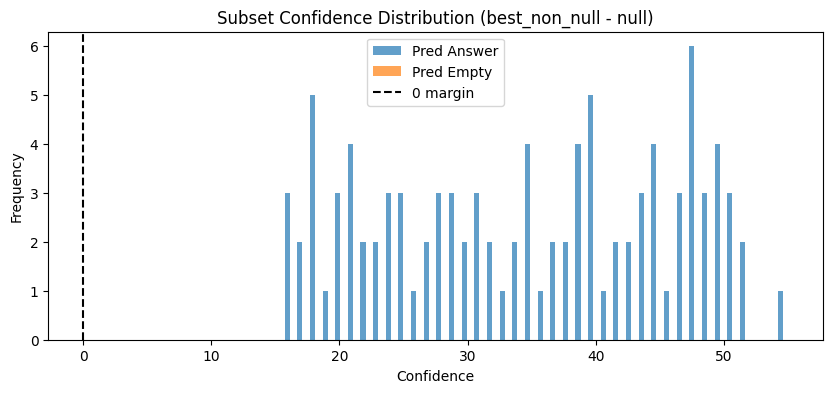

In [15]:
# Confidence analysis (subset or full if available)
import matplotlib.pyplot as plt
import numpy as np

if full_doc_meta is not None:
    meta = full_doc_meta
    label = 'Full'
elif 'doc_meta' in locals():
    meta = doc_meta
    label = 'Subset'
else:
    meta = None

if meta is not None:
    confidences = [m['chosen_confidence'] for m in meta if m['chosen_confidence'] is not None]
    empty_flags = [m['predicted_empty'] for m in meta if m['chosen_confidence'] is not None]
    has_conf = np.array([not f for f in empty_flags], dtype=bool)

    plt.figure(figsize=(10,4))
    plt.hist([np.array(confidences)[has_conf], np.array(confidences)[~has_conf]],
             bins=40, label=['Pred Answer','Pred Empty'], alpha=0.7)
    plt.axvline(0.0, color='black', linestyle='--', label='0 margin')
    plt.title(f'{label} Confidence Distribution (best_non_null - null)')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
else:
    print("ℹ️ No meta available for confidence analysis")

In [16]:
# Save results summary
import json, time

if final_metrics is not None or subset_metrics is not None:
    results_summary = {
        'checkpoint_path': EVAL_CFG.checkpoint_path,
        'subset_metrics': subset_metrics,
        'full_metrics': final_metrics,
        'used_full_eval': EVAL_CFG.use_full_eval,
        'config_overrides': {
            'no_answer_threshold': EVAL_CFG.no_answer_threshold,
            'start_top_k': EVAL_CFG.start_top_k,
            'end_top_k': EVAL_CFG.end_top_k,
            'max_answer_length': EVAL_CFG.max_answer_length
        },
        'timestamp': time.time(),
        'doc_meta_sample': (full_doc_meta[:10] if full_doc_meta else doc_meta[:10] if 'doc_meta' in locals() else [])
    }
    out_path = '../evaluation_results_memxlnet.json'
    with open(out_path, 'w') as f:
        json.dump(results_summary, f, indent=2)
    print(f"💾 Saved results to {out_path}")
else:
    print("ℹ️ No metrics available to save")

💾 Saved results to ../evaluation_results_memxlnet.json
